In [1]:
# Load necessary libraries
library(dplyr)

# Load the relative abundance data
relative_abundance <- read.csv("relative_abundance.csv", row.names = 1)




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Step 6: Correlation with melatonin (if melatonin data is available)
# Load melatonin data
melatonin_data <- read.csv("melatonin_data.csv")  # Assuming you have a CSV with melatonin levels

Study_variable <- 'Melatonin_pg_g_Stool'  

as.symbol(Study_variable)
Ages <- c('all' , '3 months', '6 months', '12 months')

Age <- Ages[4]     #'all' , '3 months', '6 months';, '12 months'


Melatonin_pg_g_Stool

In [3]:
# Load necessary libraries
library(dplyr)
library(rlang)

# Define a function to clean the data and remove outliers
remove_outliers <- function(df, column_name) {
  
  # Convert the column name to a symbol
  column_sym <- sym(column_name)
  
  # Clean the data by ensuring the specified column is non-NaN and numeric
  cleaned_data <- df %>%
    filter(!is.na(!!column_sym)) %>%
    mutate(!!column_sym := as.numeric(!!column_sym))
  
  # Calculate Q1 (25th percentile) and Q3 (75th percentile)
  Q1 <- quantile(cleaned_data[[column_name]], 0.25, na.rm = TRUE)
  Q3 <- quantile(cleaned_data[[column_name]], 0.75, na.rm = TRUE)
  
  # Calculate the IQR (Interquartile Range)
  IQR_value <- IQR(cleaned_data[[column_name]], na.rm = TRUE)
  
  # Define lower and upper bounds
  lower_bound <- Q1 - 1.5 * IQR_value
  upper_bound <- Q3 + 1.5 * IQR_value
  
  # Remove rows that are considered outliers
  cleaned_data <- cleaned_data %>%
    filter((.data[[column_name]] >= lower_bound) & (.data[[column_name]] <= upper_bound))
  
  return(cleaned_data)
}

# Example usage:
melatonin_data <- remove_outliers(melatonin_data, Study_variable)
# head(cleaned_samples)
dim(melatonin_data)


[1] 575   7

In [4]:
# Calculate mean abundance for each OTU across all samples
mean_abundance <- colMeans(relative_abundance)

# Sort OTUs by mean abundance in descending order and select the top 50 OTUs
top_50_otus <- sort(mean_abundance, decreasing = TRUE)[1:50]

# Subset the original data to only include the top 50 OTUs
top_50_otu_data <- relative_abundance %>%
  select(names(top_50_otus))

# Output the top 50 OTUs data (optional)
write.csv(top_50_otu_data, "top_50_otu_data.csv")

# Print the names of the top 50 OTUs
print(names(top_50_otus))


 [1] "ZOTU1"   "ZOTU2"   "ZOTU5"   "ZOTU3"   "ZOTU4"   "ZOTU6"   "ZOTU8"  
 [8] "ZOTU7"   "ZOTU9"   "ZOTU12"  "ZOTU10"  "ZOTU14"  "ZOTU11"  "ZOTU19" 
[15] "ZOTU15"  "ZOTU32"  "ZOTU13"  "ZOTU20"  "ZOTU16"  "ZOTU22"  "ZOTU23" 
[22] "ZOTU21"  "ZOTU17"  "ZOTU50"  "ZOTU18"  "ZOTU30"  "ZOTU24"  "ZOTU44" 
[29] "ZOTU26"  "ZOTU33"  "ZOTU34"  "ZOTU98"  "ZOTU25"  "ZOTU28"  "ZOTU29" 
[36] "ZOTU54"  "ZOTU31"  "ZOTU27"  "ZOTU56"  "ZOTU36"  "ZOTU37"  "ZOTU45" 
[43] "ZOTU39"  "ZOTU51"  "ZOTU38"  "ZOTU43"  "ZOTU152" "ZOTU46"  "ZOTU61" 
[50] "ZOTU42" 


Warning message:
"package 'pheatmap' was built under R version 4.4.1"
Warning message:
"package 'vegan' was built under R version 4.4.1"
Loading required package: permute

Warning message:
"package 'permute' was built under R version 4.4.1"
Loading required package: lattice

This is vegan 2.6-6.1



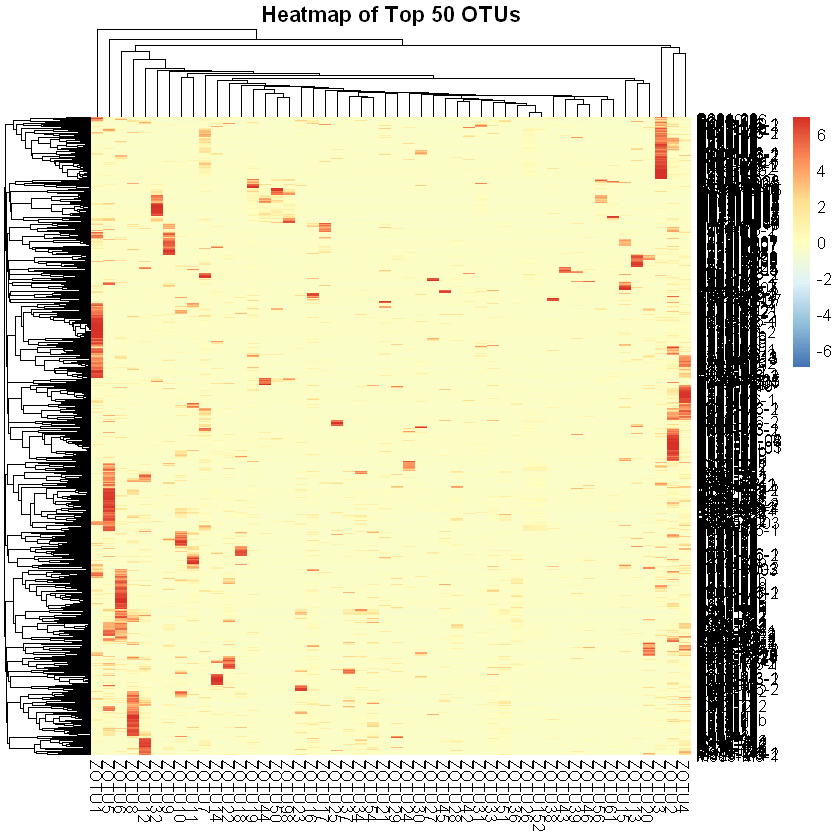

In [5]:
library(ggplot2)
library(pheatmap)
library(vegan)  # For PCA
library(dplyr)

# Step 1: Load the top 50 OTUs data
top_50_otu_data <- read.csv("top_50_otu_data.csv", row.names = 1)

# Step 2: Normalize the data (optional) - log transformation
top_50_otu_data_log <- log1p(top_50_otu_data)  # log(1 + x) to avoid issues with 0s

# Step 3: Heatmap visualization
pheatmap(as.matrix(top_50_otu_data_log), 
         scale = "row",              # Scale by row (OTUs)
         cluster_rows = TRUE,        # Cluster OTUs
         cluster_cols = TRUE,        # Cluster samples
         show_rownames = TRUE,       # Show OTU names
         show_colnames = TRUE,       # Show sample names
         main = "Heatmap of Top 50 OTUs")



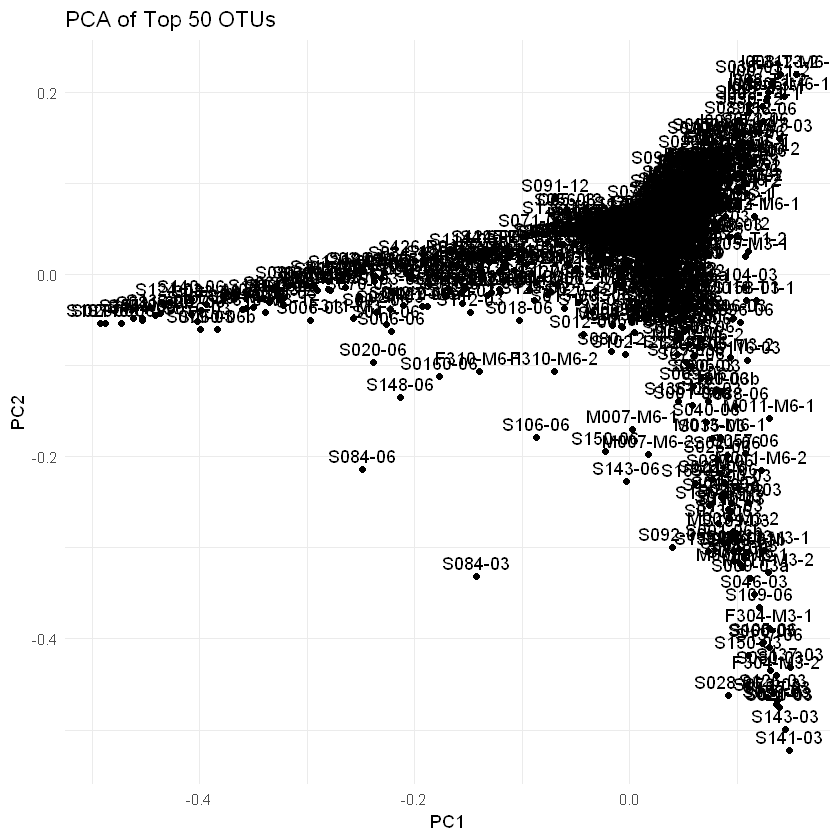

In [6]:
# Perform PCA (with or without log transformation)
pca <- rda(top_50_otu_data_log)

# Step 5: Visualize PCA results
pca_scores <- as.data.frame(scores(pca, display = "sites"))  # Extract PCA scores for samples

# Plot PCA
ggplot(pca_scores, aes(PC1, PC2)) +
  geom_point() +
  geom_text(aes(label = rownames(pca_scores)), vjust = -0.5) +
  labs(title = "PCA of Top 50 OTUs", x = "PC1", y = "PC2") +
  theme_minimal()


In [7]:
# Install the tibble package if not already installed
if (!require(tibble)) {
  install.packages("tibble")
}
# Load necessary libraries
library(tibble)

# The OTU data's row names contain the sample IDs, so we need to add them as a column
top_50_otu_data_ID <- top_50_otu_data %>%
  rownames_to_column(var = "Sample_Code_16s")  # Convert row names (sample IDs) to a column
 

Loading required package: tibble



In [8]:
# Step 4: Merge OTU data with melatonin data
# Perform the merge by the 'Sample_Code_16s' column
merged_data <- merge(top_50_otu_data_ID, melatonin_data, by = "Sample_Code_16s")

# Step 5: Check the merged dataset
head(merged_data)  # View the first few rows of the merged data


Sample_Code_16s ZOTU1       ZOTU2       ZOTU5       ZOTU3       ZOTU4      
1 S001-03         0.026430930 0.000110072 0.000020600 0.000103192 0.008069620
2 S001-12         0.003999027 0.000171011 0.000072400 0.001118149 0.006676006
3 S003-03         0.000192028 0.009743350 0.000008350 0.000050100 0.062939369
4 S003-06         0.342010282 0.005266175 0.000017900 0.000062700 0.063995665
5 S003-12         0.000085400 0.000058200 0.007573111 0.000046600 0.005919526
6 S004-06         0.016919994 0.482034839 0.011351935 0.000098700 0.073204871
  ZOTU6       ZOTU8      ZOTU7       ZOTU9      ⋯ ZOTU152     ZOTU46
1 0.000000000 0.00000688 0.000034400 0.00000000 ⋯ 0.000000000 0     
2 0.000171011 0.06346481 0.002696712 0.03865506 ⋯ 0.000000000 0     
3 0.000183679 0.00000417 0.000025000 0.00000417 ⋯ 0.000000000 0     
4 0.000519453 0.00000448 0.039393315 0.00000448 ⋯ 0.000004480 0     
5 0.001079100 0.08632027 0.000003880 0.00000388 ⋯ 0.000120331 0     
6 0.000024700 0.00000000 0.000030800 0.00003080 ⋯ 0.001079081 0     
  ZOTU61      ZOTU42     Cohort Sample_id Timepoint Day Melatonin_pg_g_Stool
1 0.000103192 0.02277793 SDEGU  S001      t1        1   100.00              
2 0.000000000 0.00003290 SDEGU  S001      t3        2   178.69              
3 0.000000000 0.00002500 SDEGU  S003      t1        1   259.23              
4 0.000000000 0.00001790 SDEGU  S003      t2        2   133.47              
5 0.000000000 0.00000000 SDEGU  S003      t3        2    81.71              
6 0.000061700 0.00001850 SDEGU  S004      t2        2   125.28              
  age_group
1  3       
2 12       
3  3       
4  6       
5 12       
6  6

In [9]:
# Step 1: Extract OTU data and melatonin levels
otu_data <- merged_data %>% select(-Sample_Code_16s, -Melatonin_pg_g_Stool, -Cohort,	-Sample_id,	-Timepoint,	-Day)  # Exclude non-OTU columns
melatonin <- merged_data$Melatonin_pg_g_Stool  # Melatonin column
ages <- merged_data$age_group
 

In [10]:
# Step 2: Calculate Spearman correlations between each OTU and melatonin levels
correlations <- apply(otu_data, 2, function(otu) cor(otu, melatonin, method = "spearman"))

# Step 3: Identify significant correlations
significant_otus <- names(correlations)[abs(correlations) > 0.1]  # Adjust threshold as needed
print(significant_otus)


[1] "ZOTU32" "ZOTU16" "ZOTU34" "ZOTU61"


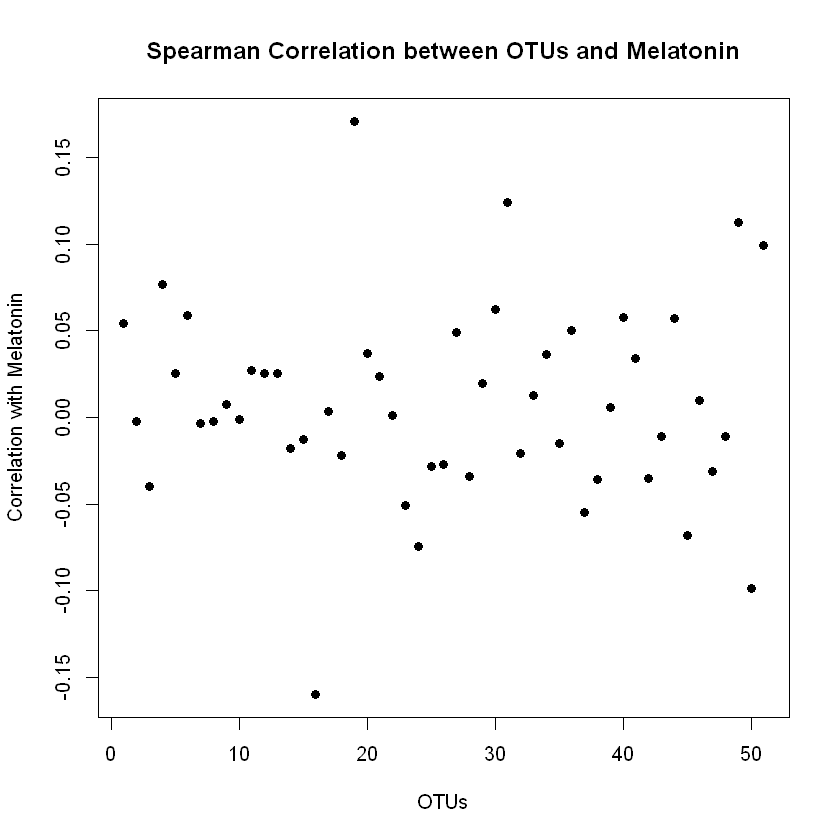

In [11]:
# Optional: Visualize correlation values
plot(correlations, main = "Spearman Correlation between OTUs and Melatonin",
     xlab = "OTUs", ylab = "Correlation with Melatonin", pch = 19)


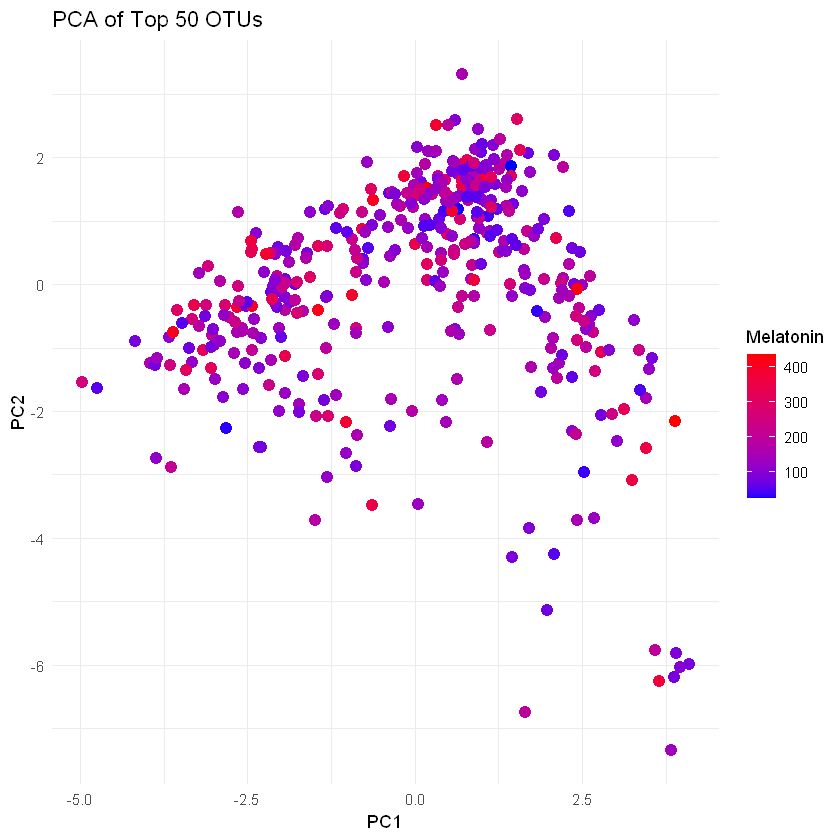

In [12]:
# Step 1: Perform PCA on the OTU data
pca <- prcomp(otu_data, scale. = TRUE)

# Step 2: Extract PCA scores for plotting
pca_scores <- as.data.frame(pca$x)

# Step 3: Add melatonin levels to the PCA scores for plotting
pca_scores$Melatonin <- melatonin

# Step 4: Plot PCA with samples colored by melatonin levels
ggplot(pca_scores, aes(PC1, PC2, color = Melatonin)) +
  geom_point(size = 3) +
  labs(title = "PCA of Top 50 OTUs", x = "PC1", y = "PC2") +
  scale_color_gradient(low = "blue", high = "red") +
  theme_minimal()


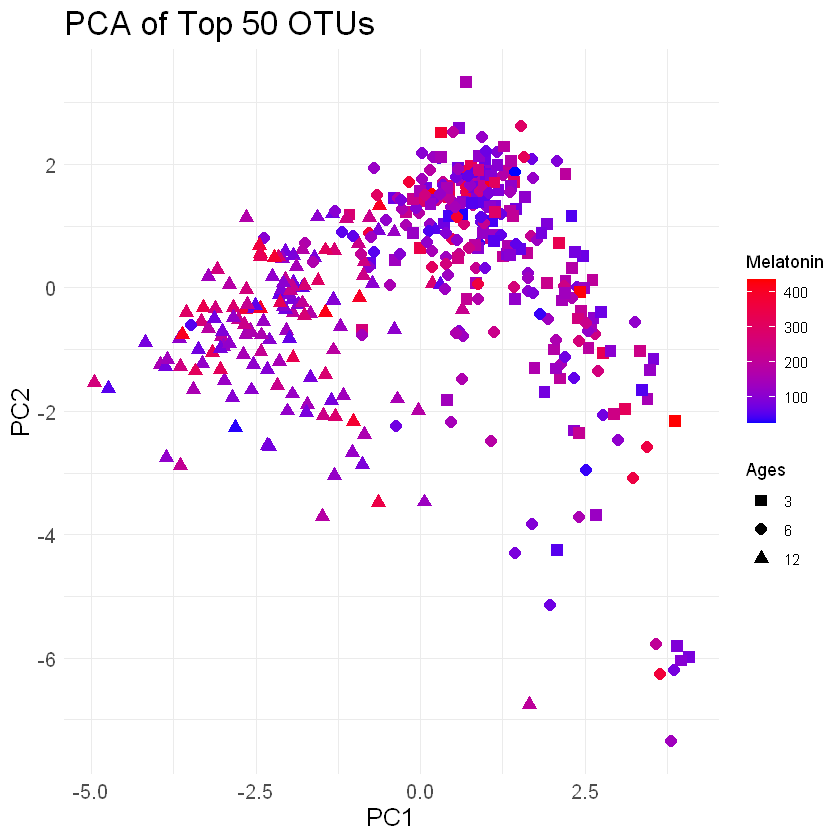

In [13]:
# Step 1: Perform PCA on the OTU data
pca <- prcomp(otu_data, scale. = TRUE)

# Step 2: Extract PCA scores for plotting
pca_scores <- as.data.frame(pca$x)

# Step 3: Add melatonin levels and ages to the PCA scores for plotting
pca_scores$Melatonin <- melatonin
pca_scores$Ages <- as.factor(ages)  # Assuming 'ages' is numeric; converting it to a factor for shape mapping

# Step 4: Plot PCA with samples colored by melatonin levels and shaped by ages
pca_plot <- ggplot(pca_scores, aes(PC1, PC2, color = Melatonin, shape = Ages)) +
  geom_point(size = 3) +  # Points colored by melatonin levels and shaped by ages
  labs(title = "PCA of Top 50 OTUs", x = "PC1", y = "PC2") +
  scale_color_gradient(low = "blue", high = "red") +  # Color gradient based on melatonin
  scale_shape_manual(values = c(15, 16, 17)) +  # Assign different shapes (e.g., square, circle, triangle)
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20),  # Increase title size
    axis.title.x = element_text(size = 15),  # Increase x-axis label size
    axis.title.y = element_text(size = 15),  # Increase y-axis label size
    axis.text.x = element_text(size = 12),   # Increase x-axis text size
    axis.text.y = element_text(size = 12)    # Increase y-axis text size
  )

# Display the plot
print(pca_plot)

# To save the plot as a larger image
ggsave("PCA_plot_large.png", plot = pca_plot, width = 10, height = 7)


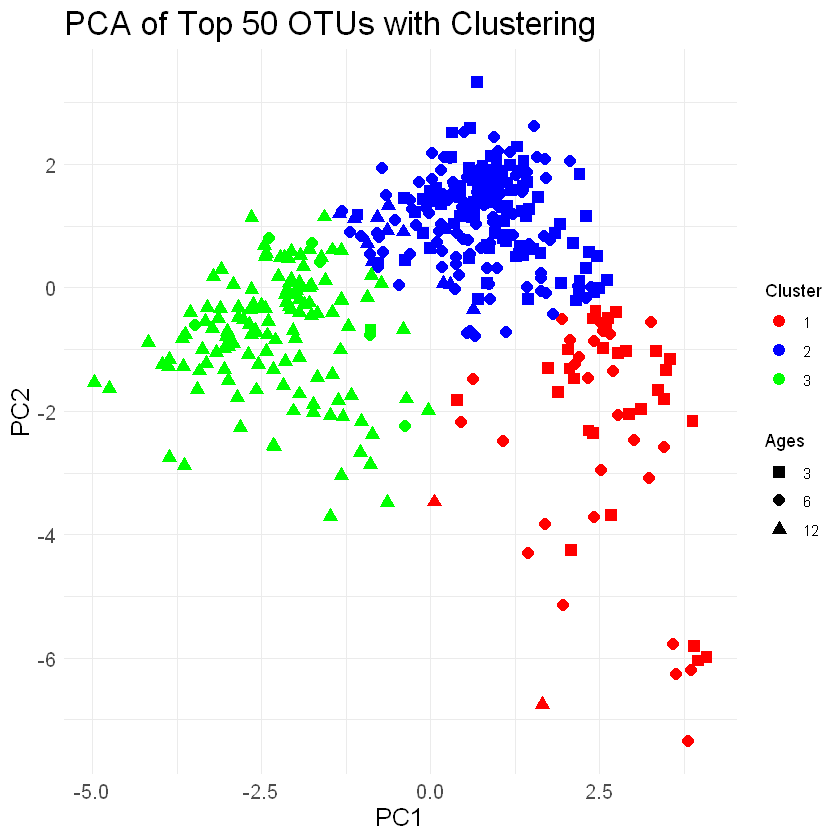

In [14]:
# Step 1: Perform PCA on the OTU data
pca <- prcomp(otu_data, scale. = TRUE)

# Step 2: Extract PCA scores for clustering and plotting
pca_scores <- as.data.frame(pca$x)

# Step 3: Add melatonin levels and ages to the PCA scores for plotting
pca_scores$Melatonin <- melatonin
pca_scores$Ages <- as.factor(ages)  # Assuming 'ages' is numeric; converting it to a factor for shape mapping

# Step 4: Perform k-means clustering (choose an appropriate number of clusters, e.g., k = 3)
set.seed(123)  # Set seed for reproducibility
kmeans_result <- kmeans(pca_scores[, c("PC1", "PC2")], centers = 3)  # Clustering based on PC1 and PC2

# Step 5: Add cluster information to the PCA scores
pca_scores$Cluster <- as.factor(kmeans_result$cluster)  # Convert to factor for coloring by cluster

# Step 6: Plot PCA with samples colored by cluster and shaped by ages
pca_plot <- ggplot(pca_scores, aes(PC1, PC2, color = Cluster, shape = Ages)) +
  geom_point(size = 3) +  # Points colored by cluster and shaped by ages
  labs(title = "PCA of Top 50 OTUs with Clustering", x = "PC1", y = "PC2") +
  scale_color_manual(values = c("red", "blue", "green")) +  # Manually assign colors for clusters
  scale_shape_manual(values = c(15, 16, 17)) +  # Assign different shapes (e.g., square, circle, triangle)
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20),  # Increase title size
    axis.title.x = element_text(size = 15),  # Increase x-axis label size
    axis.title.y = element_text(size = 15),  # Increase y-axis label size
    axis.text.x = element_text(size = 12),   # Increase x-axis text size
    axis.text.y = element_text(size = 12)    # Increase y-axis text size
  )

# Display the plot
print(pca_plot)

# To save the plot as a larger image
ggsave("PCA_plot_with_clustering_large.png", plot = pca_plot, width = 10, height = 7)


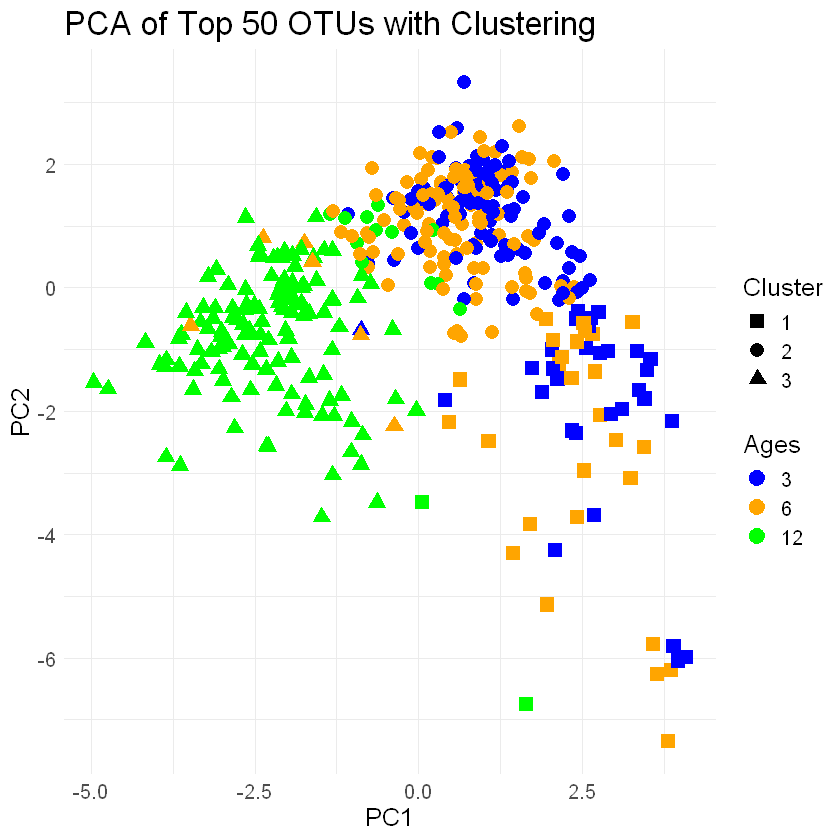

In [15]:
# Step 1: Perform PCA on the OTU data
pca <- prcomp(otu_data, scale. = TRUE)

# Step 2: Extract PCA scores for clustering and plotting
pca_scores <- as.data.frame(pca$x)

# Step 3: Add melatonin levels and ages to the PCA scores for plotting
pca_scores$Melatonin <- melatonin
pca_scores$Ages <- as.factor(ages)  # Assuming 'ages' is numeric; converting it to a factor for color mapping

# Step 4: Perform k-means clustering (choose an appropriate number of clusters, e.g., k = 3)
set.seed(123)  # Set seed for reproducibility
kmeans_result <- kmeans(pca_scores[, c("PC1", "PC2")], centers = 3)  # Clustering based on PC1 and PC2

# Step 5: Add cluster information to the PCA scores
pca_scores$Cluster <- as.factor(kmeans_result$cluster)  # Convert to factor for shape mapping by cluster

# Step 6: Plot PCA with samples colored by age and shaped by cluster
pca_plot <- ggplot(pca_scores, aes(PC1, PC2, color = Ages, shape = Cluster)) +
  geom_point(size = 3, stroke = 1.5) +  # Points colored by ages and shaped by cluster
  labs(title = "PCA of Top 50 OTUs with Clustering", x = "PC1", y = "PC2") +
  scale_color_manual(values = c("blue", "orange", "green")) +  # Assign colors for each age group
  scale_shape_manual(values = c(15, 16, 17)) +  # Assign shapes for clusters (e.g., square, circle, triangle)
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20),  # Increase title size
    axis.title.x = element_text(size = 15),  # Increase x-axis label size
    axis.title.y = element_text(size = 15),  # Increase y-axis label size
    axis.text.x = element_text(size = 12),   # Increase x-axis text size
    axis.text.y = element_text(size = 12),   # Increase y-axis text size
    legend.title = element_text(size = 15),  # Increase legend title size
    legend.text = element_text(size = 12)    # Increase legend text size
  )

# Display the plot
print(pca_plot)

# To save the plot as a larger image
ggsave("PCA_plot_color_by_age.png", plot = pca_plot, width = 10, height = 7)


In [16]:
# Step 1: Run linear regression for each OTU
regression_results <- apply(otu_data, 2, function(otu) {
  lm_result <- lm(melatonin ~ otu)
  summary(lm_result)$coefficients[2, 4]  # Return the p-value of the OTU predictor
})

# Step 2: Find OTUs with significant associations
significant_otus_lm <- names(regression_results)[regression_results < 0.1]
print(significant_otus_lm)


[1] "ZOTU6"     "ZOTU14"    "ZOTU32"    "ZOTU16"    "ZOTU50"    "ZOTU36"   
[7] "age_group"


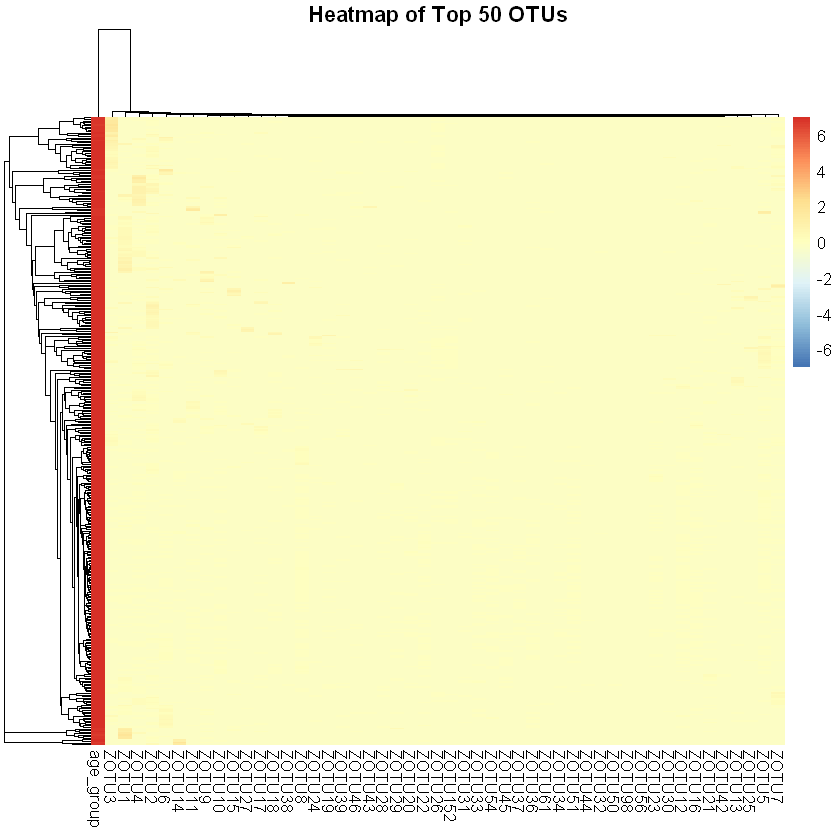

In [17]:

# Step 1: Prepare OTU data for heatmap
otu_matrix <- as.matrix(otu_data)

# Step 2: Create a heatmap with melatonin levels as annotation
pheatmap(otu_matrix,
         scale = "row",  # Standardize rows (OTUs)
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         #annotation_col = data.frame(Melatonin = melatonin),  # Annotate with melatonin
         main = "Heatmap of Top 50 OTUs")

